# Wind Power Prediction Model

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import math
from itertools import islice
import sys
import operator
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib
import os

# Column formats
headers = ["Year", "Month", "Day", "Hour", "Minute",
           "Power", "Wind Direction", "Wind Speed",
           "Temperature", "Pressure", "Height"]

headers_sec = ["Year", "Month", "Day", "Hour", "Minute",
           "Power"]

data = pd.read_csv("TrainingData/5358-2011.csv", sep=',', skiprows=4, names=headers_sec)
# print(data.head)
print(data["Power"][1])
#data = pd.read_csv("1235-2011.csv", sep=',', skiprows=4)



print(data.shape)
print("Year: ", data['Year'][len(data['Power']) - 1])
print("Month: ", data['Month'][len(data['Power']) - 1])
print("Day: ", data['Day'][len(data['Power']) - 1])
print("Hour: ", data['Hour'][len(data['Power']) - 1])
print("Minute: ", data['Minute'][len(data['Power']) - 1])

14.047
(105120, 6)
('Year: ', 2011)
('Month: ', 12)
('Day: ', 31)
('Hour: ', 23)
('Minute: ', 55)


/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
directory = "TrainingData/"
for filename in os.listdir(directory):
    site_data = pd.read_csv("TrainingData/%s" % filename, sep=',', skiprows=4, names=headers_sec)
    print(site_data['Power'].max())

16.0
16.0
16.0
16.0
16.0
16.0
16.0
16.0
10.0
14.0
12.0
14.0
16.0
6.0
14.0
14.0
14.0
14.0
12.0
12.0
10.0
16.0
14.0
2.0
16.0
16.0
14.0
16.0
16.0
16.0
16.0
14.0
16.0
16.0
16.0
16.0
16.0
14.0
16.0
16.0
10.0
16.0
14.0
10.0
16.0
16.0
16.0
16.0
16.0
16.0
12.0
10.0
12.0
16.0
16.0
16.0
16.0
16.0
14.0
16.0
16.0
16.0


KeyboardInterrupt: 

### Set the required resolution for the prediction model

In [40]:
req_resolution = 0.1 # in (MW)

max_wind_power = data['Power'].max()
min_wind_power = data['Power'].min()

# Discretise wind power
n_bins = int(math.ceil((max_wind_power - min_wind_power) / req_resolution))

print("Max Wind Power: ", max_wind_power)
print("Min Wind Power: ", min_wind_power)

# Construct transition matrix
transition_mtx = [[0.0 for i in range(n_bins + 1)] for j in range(n_bins + 1)]
#print(transition_mtx)

bin_size = (max_wind_power - min_wind_power) / n_bins

('Max Wind Power: ', 16.0)
('Min Wind Power: ', 0.0)


### Function to construct the Markov transition kernel

In [41]:
# Generates a kernel matrix based on global input CSV file
# Input: Order of Markov Chain
# Output: 2D-list (Matrix)
def construct_markov_kernel(order, normalised=True):
    
    kernel_mtx = [[0.0 for i in range(n_bins + 1)] for j in range((n_bins + 1)**order)]
        
    prev_state_idx = []
    
    headers_sec = ["Year", "Month", "Day", "Hour", "Minute",
           "Power"]
    
    directory = "TrainingData/"
    data_set_cnt = 0
    for filename in os.listdir(directory):
        data_set_cnt += 1
        print("Training Set: ", data_set_cnt)
        if data_set_cnt == 10: # Train on limited number of sites for POC
            break
        site_data = pd.read_csv("TrainingData/%s" % filename, sep=',', skiprows=4, names=headers_sec)
        
        # Scale powers w.r.t. 16 MW
        power_multiplier = 16.0 / site_data['Power'].max()
        print("Multiplier: ", power_multiplier)
        
        ### Initial state index ###
        prev_state_idx = [None for _ in range(order)]
        for i in range(order):
            power_state = site_data['Power'][i] * power_multiplier
            bin_idx = int(power_state / bin_size)
            prev_state_idx[i] = bin_idx

        for i in range(order, len(site_data) - 1):    

            curr_state_idx = int((site_data['Power'][i] * power_multiplier) / bin_size)

            # Calculate previous index
            temp_prev = 0
            for j in range(len(prev_state_idx)):
                temp_prev += prev_state_idx[j] * n_bins ** (order - j - 1)

            # Calculate current index
            temp_curr = curr_state_idx

            kernel_mtx[temp_prev][temp_curr] += 1
            
            for j in range(len(prev_state_idx) - 1):
                # Update previous index
                prev_state_idx[j] = prev_state_idx[j + 1]
                
            prev_state_idx[len(prev_state_idx) - 1] = curr_state_idx
        
    # Normalise
    if normalised:
        
        for j in range(len(kernel_mtx)):
            norm_sum = 0
            for elem in kernel_mtx[j]:
                norm_sum += elem
            if norm_sum != 0:    
                kernel_mtx[j] = [x / norm_sum for x in kernel_mtx[j]] 

    return kernel_mtx
        
        

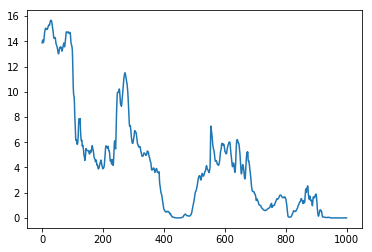

In [6]:
# Checking 'smoothness' of distribution
plt.plot(data['Power'][0:1000])

In [42]:
first_order_kernel = construct_markov_kernel(1)

('Training Set: ', 1)
('Multiplier: ', 1.0)
('Training Set: ', 2)
('Multiplier: ', 1.0)
('Training Set: ', 3)
('Multiplier: ', 1.0)
('Training Set: ', 4)
('Multiplier: ', 1.0)
('Training Set: ', 5)
('Multiplier: ', 1.0)
('Training Set: ', 6)
('Multiplier: ', 1.0)
('Training Set: ', 7)
('Multiplier: ', 1.0)
('Training Set: ', 8)
('Multiplier: ', 1.0)
('Training Set: ', 9)
('Multiplier: ', 1.6)
('Training Set: ', 10)


In [43]:
second_order_kernel = construct_markov_kernel(2)

('Training Set: ', 1)
('Multiplier: ', 1.0)
('Training Set: ', 2)
('Multiplier: ', 1.0)
('Training Set: ', 3)
('Multiplier: ', 1.0)
('Training Set: ', 4)
('Multiplier: ', 1.0)
('Training Set: ', 5)
('Multiplier: ', 1.0)
('Training Set: ', 6)
('Multiplier: ', 1.0)
('Training Set: ', 7)
('Multiplier: ', 1.0)
('Training Set: ', 8)
('Multiplier: ', 1.0)
('Training Set: ', 9)
('Multiplier: ', 1.6)
('Training Set: ', 10)


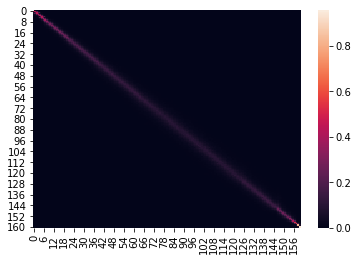

In [44]:
ax = seaborn.heatmap(first_order_kernel)

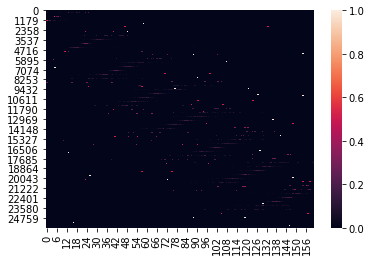

In [45]:
ax = seaborn.heatmap(second_order_kernel)

In [46]:
second_order_kernel_unnormalized = construct_markov_kernel(2, False)

('Training Set: ', 1)
('Multiplier: ', 1.0)
('Training Set: ', 2)
('Multiplier: ', 1.0)
('Training Set: ', 3)
('Multiplier: ', 1.0)
('Training Set: ', 4)
('Multiplier: ', 1.0)
('Training Set: ', 5)
('Multiplier: ', 1.0)
('Training Set: ', 6)
('Multiplier: ', 1.0)
('Training Set: ', 7)
('Multiplier: ', 1.0)
('Training Set: ', 8)
('Multiplier: ', 1.0)
('Training Set: ', 9)
('Multiplier: ', 1.6)
('Training Set: ', 10)


In [47]:
# Aggregate second kernel to first order kernel

aggr_mtx = [[0.0 for i in range(n_bins + 1)] for j in range(n_bins + 1)]

for i in range(n_bins + 1):
    row_sum = [0.0 for _ in range(n_bins + 1)]
    for j in range(n_bins + 1):
        row_sum = [x + y for x, y in zip(row_sum, second_order_kernel_unnormalized[i + j * n_bins])]
    aggr_mtx[i] = row_sum
    
# Normalize
for j in range(len(aggr_mtx)):
            norm_sum = 0
            for elem in aggr_mtx[j]:
                norm_sum += elem
            if norm_sum != 0:    
                aggr_mtx[j] = [x / norm_sum for x in aggr_mtx[j]] 

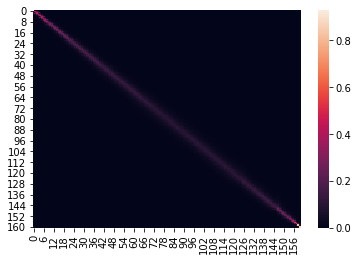

In [48]:
ax = seaborn.heatmap(aggr_mtx)

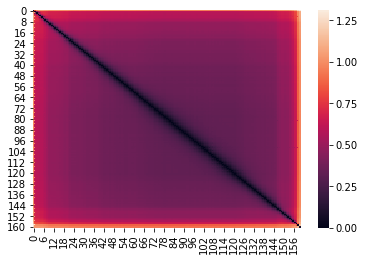

In [52]:
# Euclidean Distance
def euclidean(v1, v2):
    return sum((p-q)**2 for p, q in zip(v1, v2)) ** .5

d2 = []
for i in aggr_mtx:
    foo = [euclidean(i, j) for j in first_order_kernel]
    d2.append(foo)
ax = seaborn.heatmap(d2)   

In [55]:
if aggr_mtx == first_order_kernel:
    print("You fucked up!")
else:
    print("No we're good")

No we're good


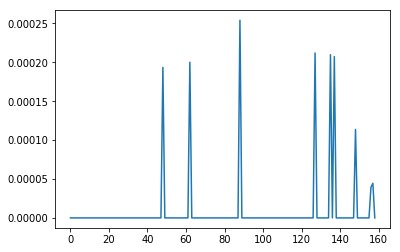

In [61]:
from scipy.spatial import distance

dist = []
for idx, row in enumerate(aggr_mtx):
    if idx == 0 or idx == (len(aggr_mtx) - 1):
        continue
    foo = distance.euclidean(row, first_order_kernel[idx])
    if foo > 0.00050:
        continue
    dist.append(foo)
plt.plot(dist)

In [1]:
# Use this one!
# *************
def construct_aux_mtx(order, normalised=True):
    
    # One kernel to rule them all
    kernel_mtx = [[0.0 for i in range((n_bins + 1)**order)] for j in range((n_bins + 1)**order)]
    
    ### Size of kernel ###
    print("Size: ", sys.getsizeof(kernel_mtx))
    print("Dimensions: ", len(kernel_mtx), len(kernel_mtx[0]))
    
    headers_sec = ["Year", "Month", "Day", "Hour", "Minute",
           "Power"]
    
    directory = "TrainingData/"
    data_set_cnt = 0
    for filename in os.listdir(directory):
        data_set_cnt += 1
        print("Training Set: ", data_set_cnt)
        if data_set_cnt == 10:
            break
        site_data = pd.read_csv("TrainingData/%s" % filename, sep=',', skiprows=4, names=headers_sec)
        
        # Scale powers w.r.t. 16 MW
        power_multiplier = 16.0 / site_data['Power'].max()
        print("Multiplier: ", power_multiplier)
        
        ### Initial state index ###
        prev_state_idx = [None for _ in range(order)]
        for i in range(0, order):
            power_state = site_data['Power'][i] * power_multiplier
            bin_idx = int(power_state / bin_size)
#             print("Bin index: ", bin_idx)
            prev_state_idx[i] = bin_idx
            #prev_state_idx += (bin_idx + 1) * (n_bins_test + 1) * (order - 1 - i)

        curr_state_idx = [None for _ in range(order)]
        curr_state_idx[0] = prev_state_idx[1]

        for i in range(order, len(site_data) - 1):    

            curr_state_idx[1] = int((site_data['Power'][i] * power_multiplier) / bin_size)

            # Calculate previous index
            temp_prev = 0
            for j in range(len(prev_state_idx)):
                temp_prev += prev_state_idx[j] * n_bins ** (order - j - 1)

            # Calculate current index
            temp_curr = 0
            for j in range(len(curr_state_idx)):
                temp_curr += curr_state_idx[j] * n_bins ** (order - j - 1)

            kernel_mtx[temp_prev][temp_curr] += 1

            # Update previous index
            prev_state_idx[0] = prev_state_idx[1]
            prev_state_idx[1] = curr_state_idx[0]

            # Update 'next' current index
            curr_state_idx[0] = curr_state_idx[1]
        
        
    # Normalise
    if normalised:
        
        for j in range(len(kernel_mtx)):
            norm_sum = 0
            for elem in kernel_mtx[j]:
                norm_sum += elem
            if norm_sum != 0:    
                kernel_mtx[j] = [x / norm_sum for x in kernel_mtx[j]] 

    return kernel_mtx

In [15]:
second_transition_mtx = construct_aux_mtx(2)

('Size: ', 9032)
('Dimensions: ', 1089, 1089)
('Training Set: ', 1)
('Multiplier: ', 1.0)
('Training Set: ', 2)
('Multiplier: ', 1.0)
('Training Set: ', 3)
('Multiplier: ', 1.0)
('Training Set: ', 4)
('Multiplier: ', 1.0)
('Training Set: ', 5)
('Multiplier: ', 1.0)
('Training Set: ', 6)
('Multiplier: ', 1.0)
('Training Set: ', 7)
('Multiplier: ', 1.0)
('Training Set: ', 8)
('Multiplier: ', 1.0)
('Training Set: ', 9)
('Multiplier: ', 1.6)
('Training Set: ', 10)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 11)
('Multiplier: ', 1.3333333333333333)
('Training Set: ', 12)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 13)
('Multiplier: ', 1.0)
('Training Set: ', 14)
('Multiplier: ', 2.6666666666666665)
('Training Set: ', 15)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 16)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 17)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 18)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 19)
('Multipli

('Training Set: ', 169)
('Multiplier: ', 2.0)
('Training Set: ', 170)
('Multiplier: ', 1.0)
('Training Set: ', 171)
('Multiplier: ', 1.0)
('Training Set: ', 172)
('Multiplier: ', 1.0)
('Training Set: ', 173)
('Multiplier: ', 1.0)
('Training Set: ', 174)
('Multiplier: ', 1.0)
('Training Set: ', 175)
('Multiplier: ', 1.6)
('Training Set: ', 176)
('Multiplier: ', 1.0)
('Training Set: ', 177)
('Multiplier: ', 1.0)
('Training Set: ', 178)
('Multiplier: ', 1.0)
('Training Set: ', 179)
('Multiplier: ', 1.0)
('Training Set: ', 180)
('Multiplier: ', 1.0)
('Training Set: ', 181)
('Multiplier: ', 1.0)
('Training Set: ', 182)
('Multiplier: ', 1.6)
('Training Set: ', 183)
('Multiplier: ', 2.0)
('Training Set: ', 184)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 185)
('Multiplier: ', 1.0)
('Training Set: ', 186)
('Multiplier: ', 1.0)
('Training Set: ', 187)
('Multiplier: ', 1.0)
('Training Set: ', 188)
('Multiplier: ', 1.0)
('Training Set: ', 189)
('Multiplier: ', 1.0)
('Training Set: ', 

In [24]:
def construct_aux_mtx_unnormalized(order, normalised=True):
    
    # One kernel to rule them all
    kernel_mtx = [[0.0 for i in range((n_bins + 1)**order)] for j in range((n_bins + 1)**order)]
    
    ### Size of kernel ###
    print("Size: ", sys.getsizeof(kernel_mtx))
    print("Dimensions: ", len(kernel_mtx), len(kernel_mtx[0]))
    
    headers_sec = ["Year", "Month", "Day", "Hour", "Minute",
           "Power"]
    
    directory = "TrainingData/"
    data_set_cnt = 0
    for filename in os.listdir(directory):
        data_set_cnt += 1
        print("Training Set: ", data_set_cnt)
        site_data = pd.read_csv("TrainingData/%s" % filename, sep=',', skiprows=4, names=headers_sec)
        
        # Scale powers w.r.t. 16 MW
        power_multiplier = 16.0 / site_data['Power'].max()
        print("Multiplier: ", power_multiplier)
        
        ### Initial state index ###
        prev_state_idx = [None for _ in range(order)]
        for i in range(0, order):
            power_state = site_data['Power'][i] * power_multiplier
            bin_idx = int(power_state / bin_size)
#             print("Bin index: ", bin_idx)
            prev_state_idx[i] = bin_idx
            #prev_state_idx += (bin_idx + 1) * (n_bins_test + 1) * (order - 1 - i)

        curr_state_idx = [None for _ in range(order)]
        curr_state_idx[0] = prev_state_idx[1]

        for i in range(order, len(site_data) - 1):    

            curr_state_idx[1] = int((site_data['Power'][i] * power_multiplier) / bin_size)

            # Calculate previous index
            temp_prev = 0
            for j in range(len(prev_state_idx)):
                temp_prev += prev_state_idx[j] * n_bins ** (order - j - 1)

            # Calculate current index
            temp_curr = 0
            for j in range(len(curr_state_idx)):
                temp_curr += curr_state_idx[j] * n_bins ** (order - j - 1)

            kernel_mtx[temp_prev][temp_curr] += 1

            # Update previous index
            prev_state_idx[0] = prev_state_idx[1]
            prev_state_idx[1] = curr_state_idx[0]

            # Update 'next' current index
            curr_state_idx[0] = curr_state_idx[1]
        
    return kernel_mtx

In [25]:
second_transition_mtx_unnormalized = construct_aux_mtx_unnormalized(2)

('Size: ', 225416)
('Dimensions: ', 25921, 25921)
('Training Set: ', 1)
('Multiplier: ', 1.0)
('Training Set: ', 2)
('Multiplier: ', 1.0)
('Training Set: ', 3)
('Multiplier: ', 1.0)
('Training Set: ', 4)
('Multiplier: ', 1.0)
('Training Set: ', 5)
('Multiplier: ', 1.0)
('Training Set: ', 6)
('Multiplier: ', 1.0)
('Training Set: ', 7)
('Multiplier: ', 1.0)
('Training Set: ', 8)
('Multiplier: ', 1.0)
('Training Set: ', 9)
('Multiplier: ', 1.6)
('Training Set: ', 10)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 11)
('Multiplier: ', 1.3333333333333333)
('Training Set: ', 12)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 13)
('Multiplier: ', 1.0)
('Training Set: ', 14)
('Multiplier: ', 2.6666666666666665)
('Training Set: ', 15)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 16)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 17)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 18)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 19)
('Mult

('Training Set: ', 169)
('Multiplier: ', 2.0)
('Training Set: ', 170)
('Multiplier: ', 1.0)
('Training Set: ', 171)
('Multiplier: ', 1.0)
('Training Set: ', 172)
('Multiplier: ', 1.0)
('Training Set: ', 173)
('Multiplier: ', 1.0)
('Training Set: ', 174)
('Multiplier: ', 1.0)
('Training Set: ', 175)
('Multiplier: ', 1.6)
('Training Set: ', 176)
('Multiplier: ', 1.0)
('Training Set: ', 177)
('Multiplier: ', 1.0)
('Training Set: ', 178)
('Multiplier: ', 1.0)
('Training Set: ', 179)
('Multiplier: ', 1.0)
('Training Set: ', 180)
('Multiplier: ', 1.0)
('Training Set: ', 181)
('Multiplier: ', 1.0)
('Training Set: ', 182)
('Multiplier: ', 1.6)
('Training Set: ', 183)
('Multiplier: ', 2.0)
('Training Set: ', 184)
('Multiplier: ', 1.1428571428571428)
('Training Set: ', 185)
('Multiplier: ', 1.0)
('Training Set: ', 186)
('Multiplier: ', 1.0)
('Training Set: ', 187)
('Multiplier: ', 1.0)
('Training Set: ', 188)
('Multiplier: ', 1.0)
('Training Set: ', 189)
('Multiplier: ', 1.0)
('Training Set: ', 

In [29]:
## Aggregate 2nd order Markov kernel to 1st Order

# Create a duplicate kernel to experiment on
temp_kernel_mtx = second_transition_mtx_unnormalized

print("Duplicated")

# Aggregate rows first
row_aggr_mtx = [[0.0 for i in range((n_bins + 1)**2)] for j in range(n_bins + 1)]
print("Created row aggregation")
print("Size: ", len(row_aggr_mtx), len(row_aggr_mtx[0]))

for i in range(len(row_aggr_mtx)):
    print("Aggregation: ", i)
    row_aggr_sum = [0.0 for j in range((n_bins + 1)**2)]
    for j in range(n_bins + 1):
        row_aggr_sum = [x + y for x, y in zip(row_aggr_sum, temp_kernel_mtx[i + j * n_bins])]
        
    row_aggr_mtx[i] = row_aggr_sum
    
# Now aggregate columns
col_aggr_mtx = [[0.0 for i in range(n_bins + 1)] for j in range(n_bins + 1)]

for i in range(len(col_aggr_mtx) - 1):
    col_aggr_mtx[i] = row_aggr_mtx[i][i * (n_bins + 1): (i + 1) * (n_bins + 1)]





Duplicated
Created row aggregation
('Size: ', 161, 25921)
('Aggregation: ', 0)
('Aggregation: ', 1)
('Aggregation: ', 2)
('Aggregation: ', 3)
('Aggregation: ', 4)
('Aggregation: ', 5)
('Aggregation: ', 6)
('Aggregation: ', 7)
('Aggregation: ', 8)
('Aggregation: ', 9)
('Aggregation: ', 10)
('Aggregation: ', 11)
('Aggregation: ', 12)
('Aggregation: ', 13)
('Aggregation: ', 14)
('Aggregation: ', 15)
('Aggregation: ', 16)
('Aggregation: ', 17)
('Aggregation: ', 18)
('Aggregation: ', 19)
('Aggregation: ', 20)
('Aggregation: ', 21)
('Aggregation: ', 22)
('Aggregation: ', 23)
('Aggregation: ', 24)
('Aggregation: ', 25)
('Aggregation: ', 26)
('Aggregation: ', 27)
('Aggregation: ', 28)
('Aggregation: ', 29)
('Aggregation: ', 30)
('Aggregation: ', 31)
('Aggregation: ', 32)
('Aggregation: ', 33)
('Aggregation: ', 34)
('Aggregation: ', 35)
('Aggregation: ', 36)
('Aggregation: ', 37)
('Aggregation: ', 38)
('Aggregation: ', 39)
('Aggregation: ', 40)
('Aggregation: ', 41)
('Aggregation: ', 42)
('Aggr

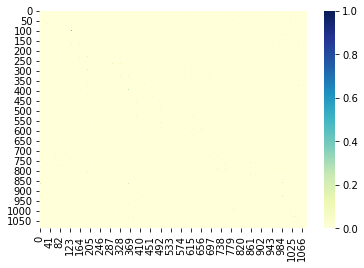

In [17]:
ax = seaborn.heatmap(second_transition_mtx, cmap="YlGnBu")

In [6]:
import pickle
with open("pickle_dump.txt", "wb") as fp:   #Pickling
   pickle.dump(second_transition_mtx, fp)

KeyboardInterrupt: 

In [23]:
print(data['Power'][400], data['Power'][401])
print(data['Power'].max())
print(n_bins, bin_size)
print(int(data['Power'][400] / bin_size) * n_bins + int(data['Power'][401] / bin_size))

(0.677, 0.637)
16.0
(160, 0.1)
966


In [ ]:
ax = seaborn.heatmap(second_transition_mtx)

Current state vector initialized
Generated currenrt index
Start vector initialisation complete
Numpy conversions done
Generated future kernel
Prediction complete


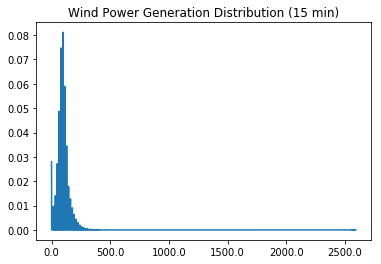

In [7]:
# Initialise start state
curr_state_vec = [0.0 for i in range((n_bins + 1)**2)]
print("Current state vector initialized")
curr_state_idx = int(data['Power'][400] / bin_size) * n_bins + int(data['Power'][401] / bin_size)
print("Generated currenrt index")
curr_state_vec[curr_state_idx] = 1

print("Start vector initialisation complete")

# Numpy conversion
curr_state_vec_np    = np.array(curr_state_vec)
transition_kernel_np = np.array(second_transition_mtx)

print("Numpy conversions done")

future_time = 15 # min
num_steps = future_time / 5

transition_kernel_np_fifteen = np.linalg.matrix_power(transition_kernel_np, num_steps)

print("Generated future kernel")

# Generate prediction
future_state_vec_np = curr_state_vec_np.dot(transition_kernel_np_fifteen)

print("Prediction complete")

fig, ax = plt.subplots()

def numfmt(x, pos): # custom formatter function: divide by 10.0
    s = '{}'.format(x / (1 / req_resolution))
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
xfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.xaxis.set_major_formatter(xfmt)

plt.plot(future_state_vec_np)
plt.title("Wind Power Generation Distribution (15 min)")
plt.show()


Prediction complete


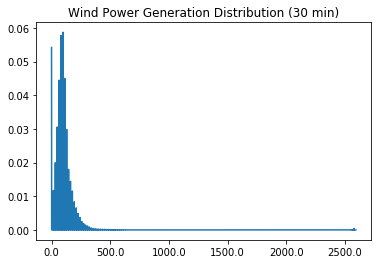

In [8]:

# Generate prediction
future_state_vec_np = future_state_vec_np.dot(transition_kernel_np)

print("Prediction complete")

fig, ax = plt.subplots()

def numfmt(x, pos): # custom formatter function: divide by 10.0
    s = '{}'.format(x / (1 / req_resolution))
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
xfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.xaxis.set_major_formatter(xfmt)

plt.plot(future_state_vec_np)
plt.title("Wind Power Generation Distribution (30 min)")
plt.show()

Prediction complete


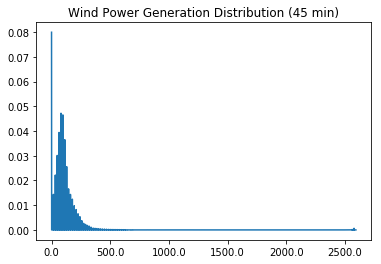

In [9]:
# Generate prediction
future_state_vec_np = future_state_vec_np.dot(transition_kernel_np)

print("Prediction complete")

fig, ax = plt.subplots()

def numfmt(x, pos): # custom formatter function: divide by 10.0
    s = '{}'.format(x / (1 / req_resolution))
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
xfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.xaxis.set_major_formatter(xfmt)

plt.plot(future_state_vec_np)
plt.title("Wind Power Generation Distribution (45 min)")
plt.show()

Prediction complete


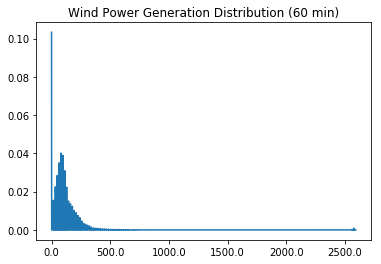

In [10]:
# Generate prediction
future_state_vec_np = future_state_vec_np.dot(transition_kernel_np)

print("Prediction complete")

fig, ax = plt.subplots()

def numfmt(x, pos): # custom formatter function: divide by 10.0
    s = '{}'.format(x / (1 / req_resolution))
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
xfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.xaxis.set_major_formatter(xfmt)

plt.plot(future_state_vec_np)
plt.title("Wind Power Generation Distribution (60 min)")
plt.show()

Prediction complete


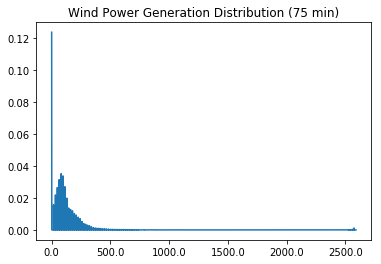

In [11]:
# Generate prediction
future_state_vec_np = future_state_vec_np.dot(transition_kernel_np)

print("Prediction complete")

fig, ax = plt.subplots()

def numfmt(x, pos): # custom formatter function: divide by 10.0
    s = '{}'.format(x / (1 / req_resolution))
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
xfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.xaxis.set_major_formatter(xfmt)

plt.plot(future_state_vec_np)
plt.title("Wind Power Generation Distribution (75 min)")
plt.show()

Prediction complete


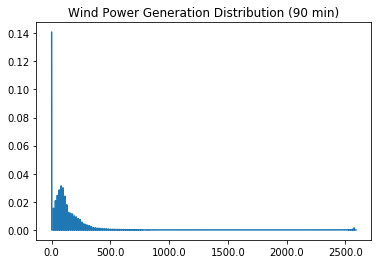

In [12]:
# Generate prediction
future_state_vec_np = future_state_vec_np.dot(transition_kernel_np)

print("Prediction complete")

fig, ax = plt.subplots()

def numfmt(x, pos): # custom formatter function: divide by 10.0
    s = '{}'.format(x / (1 / req_resolution))
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
xfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.xaxis.set_major_formatter(xfmt)

plt.plot(future_state_vec_np)
plt.title("Wind Power Generation Distribution (90 min)")
plt.show()

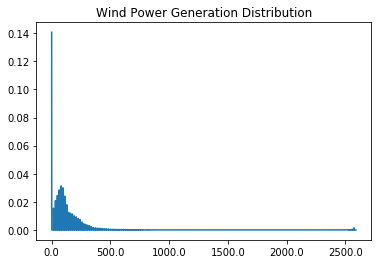

In [13]:
fig, ax = plt.subplots()

def numfmt(x, pos): # custom formatter function: divide by 10.0
    s = '{}'.format(x / (1 / req_resolution))
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
xfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.xaxis.set_major_formatter(xfmt)

plt.plot(future_state_vec_np)
plt.title("Wind Power Generation Distribution")
plt.show()



In [6]:
# Calculating error in distribution
distribution_cache = {}

for i in range(0, len(data) - 1):

    #print(data['Power'][i])
    if data['Power'][i] not in distribution_cache:
        distribution_cache[data['Power'][i]] = []
    else:
        distribution_cache[data['Power'][i]].append(data['Power'][i] - data['Power'][i + 1])


(array([2.468e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 8.500e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 4.200e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.300e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.900e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 8.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+0

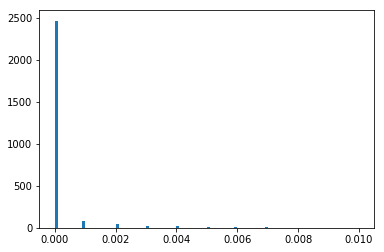

In [35]:
matplotlib.pyplot.hist(distribution_cache[16.0], bins=100, range=(0, 0.01))


In [14]:
# Calculate variance
state_variance = {}
for key, val in distribution_cache.iteritems():
    if val:
        state_variance[key] = np.var(np.asarray(val))
        

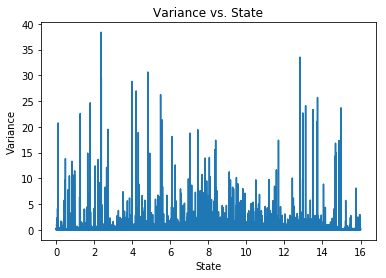

In [21]:
sorted_variance = sorted(state_variance.items(), key=operator.itemgetter(0))
x_val = []
y_val = []
for p in sorted_variance:
    x_val.append(p[0])
    y_val.append(p[1])
plt.title("Variance vs. State")
plt.xlabel("State")
plt.ylabel("Variance")
plt.plot(x_val, y_val)    

In [51]:
min_power_ctr = 0
max_power_ctr = 0
for i in range(0, len(data) - 1):
    if int(data['Power'][i]) == 0:
        min_power_ctr += 1
    elif int(data['Power'][i]) == 16:
        max_power_ctr += 1

print(min_power_ctr, max_power_ctr, len(data))
print(min_power_ctr / len(data))
print(max_power_ctr / len(data))

(20959, 2690, 105120)
0
0


### Data Preparation for NN

In [34]:
# *** Training data ***

print("Loading training data...")

num_train_months = range(1, 10) # Number of months to use as training data
time_train_x  = []
power_train_y = []

curr_time = 0
last_idx  = -1 
for i in range(0, len(data) - 1):
    
    curr_month = data['Month'][i]
    if curr_month in num_train_months:
        time_train_x.append(curr_time)
        curr_time += 5
        power_train_y.append(data['Power'][i])
    else:
        last_idx = i
        break

print("Done!")
time_train_x  = np.asarray(time_train_x, dtype=np.float32)
power_train_y = np.asarray(power_train_y, dtype=np.float32)


# *** Verification data ***

print("Loading verification data...")
num_pred_months = range(10, 12+1) # Number of months to use as verification data
time_pred_x  = []
power_pred_y = []

for i in range(last_idx, len(data) - 1):
    
    curr_month = data['Month'][i]
    if curr_month in num_pred_months:
        time_pred_x.append(curr_time)
        curr_time += 5
        power_pred_y.append(data['Power'][i])

print("Done!")
time_pred_x  = np.asarray(time_pred_x, dtype=np.float32)
power_pred_y = np.asarray(power_pred_y, dtype=np.float32)


Loading training data...
Done!
Loading verification data...
Done!


In [ ]:
# Training the model

alpha = 0.95

clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_upper = clf.predict(xx)

clf.set_params(alpha=1.0 - alpha)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_lower = clf.predict(xx)

clf.set_params(loss='ls')
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

### Function to visualise the transition kernel heatmap

In [4]:
def plot_kernel_heatmap(transition_mtx):

    ax = seaborn.heatmap(transition_mtx, cmap="Greens")
    ax.set_title('Kernel Heatmap')    
    ax.set(xlabel='Next State', ylabel='Previous State(s)')


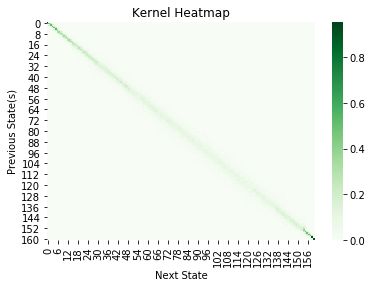

In [5]:
first_order_kernel = construct_markov_kernel(1)
plot_kernel_heatmap(first_order_kernel)

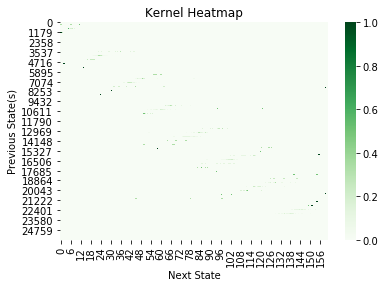

In [6]:
second_order_kernel = construct_markov_kernel(2)
plot_kernel_heatmap(second_order_kernel)

### Predicting future distribution using 1st Order Markov Chain

In [27]:
# Initialise start state
curr_state_vec = [0.0 for i in range(n_bins + 1)]
curr_state_idx = int(data['Power'][0] / bin_size)
curr_state_vec[curr_state_idx] = 1

# Numpy conversion
curr_state_vec_np    = np.array(curr_state_vec)
transition_kernel_np = np.array(first_order_kernel)

transition_kernel_np = np.linalg.matrix_power(transition_kernel_np, 60)

# Generate prediction
future_state_vec_np = curr_state_vec_np.dot(transition_kernel_np)


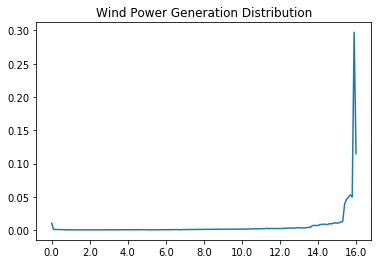

In [28]:
fig, ax = plt.subplots()

def numfmt(x, pos): # custom formatter function: divide by 10.0
    s = '{}'.format(x / (1 / req_resolution))
    return s

import matplotlib.ticker as tkr     # has classes for tick-locating and -formatting
xfmt = tkr.FuncFormatter(numfmt)    # create your custom formatter function

# your existing code can be inserted here

ax.xaxis.set_major_formatter(xfmt)

plt.plot(future_state_vec_np)
plt.title("Wind Power Generation Distribution")
plt.show()


In [3]:

# Initial assumption
init_power = data['Power'][0]

prev_power_val = init_power
latest_power_val = None

for index, row in data.iterrows():

    prev_power_idx = int(prev_power_val / bin_size)
    prev_power_val = row['Power']
    curr_power_idx = int(prev_power_val / bin_size)

    # Update transition matrix
    transition_mtx[prev_power_idx][curr_power_idx] += 1

    prev_power_val = row['Power']
    
num_data_points = data['Power'].count()

raw_transition_mtx = transition_mtx

In [4]:
# Normalise each row of transition matrix 

for index, row in enumerate(transition_mtx):
    norm_sum = 0
    for elem in transition_mtx[index]:
        norm_sum += elem
    transition_mtx[index] = [x / norm_sum for x in transition_mtx[index]]

### Benchmark for Markov Chain Order
#### - Checking for independence of state transition events
#### P( State S[t+1] reached from State S[t] | State S[i] was before State S[t])
#### = P( State S[t+1] reached from State S[t]) # To guarantee first-order independence

#### Error Factor == {P(E1) - P(E1.E2)/P(E2)}

In [7]:
# Error factor calculation

first_order_error_factor = 0

for curr_state_idx, next_states in enumerate(transition_mtx):
    
    max_state_idx = 0
    max_probability = 0
    has_next_state = False
    for state_idx, state_probability in enumerate(next_states):
        if state_probability > max_probability:
            max_probability = state_probability
            max_state_idx = state_idx
            has_next_state = True
    
    if has_next_state:
        
        for i in range(0, n_bins + 1):
            # print((n_bins + 1) * i + curr_state_idx)
            row_sum = sum(second_order_transition_mtx[(n_bins + 1) * i + curr_state_idx])
            if row_sum != 0:
                second_order_state_probability = second_order_transition_mtx[(n_bins + 1) * i + curr_state_idx][max_state_idx]
                if second_order_state_probability != 0:
                    col_totals = [ sum(x) for x in zip(*raw_transition_mtx) ]
                    back_probability = raw_transition_mtx[i][curr_state_idx]/col_totals[curr_state_idx]
                    if back_probability != 0:
                        first_order_error_factor += (max_probability - second_order_state_probability/back_probability)**2
                    
print("Error Factor: ", first_order_error_factor)                    

('Error Factor: ', 305716607.5571029)


### Heatmap for Second Order Markov Chain

Text(0.5,1,'Second-Order Markov Chain')

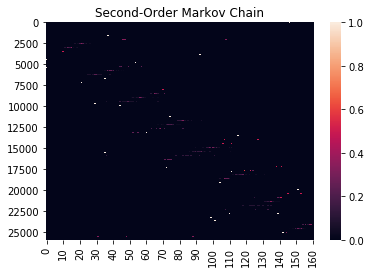

In [8]:
# Normalise each row of transition matrix 

for index, row in enumerate(second_order_transition_mtx):
    sum = 0
    for elem in second_order_transition_mtx[index]:
        sum += elem
    if sum != 0:    
        second_order_transition_mtx[index] = [x / sum for x in second_order_transition_mtx[index]]

# # Plot heatmap    

# y, x = np.meshgrid(np.linspace(min_wind_power, max_wind_power, (n_bins + 1)**2), np.linspace(min_wind_power, max_wind_power, n_bins))

# z = np.array(second_order_transition_mtx)
# #print(z)
# # x and y are bounds, so z should be the value *inside* those bounds.
# # Therefore, remove the last value from the z array.
# z = z[:-1, :-1]
# z_min, z_max = np.abs(z).min(), np.abs(z).max() # Tweak parameter for

# fig, ax = plt.subplots()

# c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
# ax.set_title('1st Order Markov Chain Heatmap')
# # set the limits of the plot to the limits of the data
# ax.axis([x.min(), x.max(), y.min(), y.max()])
# fig.colorbar(c, ax=ax)

# plt.show()

# # Heatmap alternative plot
# plt.imshow(second_order_transition_mtx, cmap='hot', interpolation='nearest')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.axis('tight')
# plt.show()
# plt.axes.Axes.set_xscale(1, 'linear')

ax = seaborn.heatmap(second_order_transition_mtx, xticklabels=10, yticklabels=2500)
ax.set_title('Second-Order Markov Chain')

# numpy_transition_mtx = np.array(second_order_transition_mtx)

# num_plots = 0
# for index in range(len(second_order_transition_mtx)):
#     plt.plot(numpy_transition_mtx[index,:])
#     num_plots += 1
#     if num_plots == 50:
#         break
# plt.title("Probability Distributions of Bins")
# plt.show()

In [ ]:
# # Construct a third order transition matrix
third_order_transition_mtx = [[0.0 for i in range(n_bins + 1)] for j in range((n_bins + 1)**3)]

# Initial assumption
first_power_state = init_power
second_power_state = data['Power'][1]
third_power_state = data['Power'][2]

for index, row in islice(df.iterrows(), 3, None)

    prev_power_first_idx = int(first_power_state / bin_size)
    prev_power_second_idx = int(second_power_state / bin_size)
    prev_power_third_idx = int(third_power_state / bin_size)
    
    first_power_state = second_power_state
    second_power_state = row['Power']
    
    curr_power_idx = int(second_power_state / bin_size)

    # Update transition matrix
    #print(prev_power_first_idx * n_bins + prev_power_second_idx)
    second_order_transition_mtx[prev_power_first_idx * n_bins + prev_power_second_idx][curr_power_idx] += 1

    latest_power_val = row['Power']
    
num_data_points = data['Power'].count()

In [1]:
# Generates a kernel matrix based on global input CSV file
# Input: Order of Markov Chain
# Output: 2D-list (Matrix)
def construct_markov_kernel(order, normalised=True):
    
    kernel_mtx = [[0.0 for i in range(n_bins + 1)] for j in range((n_bins + 1)**order)]
    
    power_state = []
    
    # Initial assumption
    for i in range(order):
        power_state.append(data['Power'][i])
        
    for idx, row in islice(df.iterrows(), order, None): # Skip initial rows based on order
        
        prev_idx = [-1 for _ in range(order)]
        for j, elem in enumerate(prev_idx):
            elem = int(power_state[j] / bin_size)
        
        # Update power states
        for i in range(order - 1):
            power_state[i] = power_state[i + 1]
        power_state[order - 1] = row['Power']
        
        curr_power_idx = int(power_state[order - 1])
        
        # Update transition matrix
            kernel_prev_idx = 0
            for i in range(order - 1):
                kernel_prev_idx += prev_idx[i] * n_bins * (order - i - 1)
            kernel_prev_idx += prev_idx[order - 1]    
            kernel_mtx[kernel_prev_idx][curr_power_idx] += 1
            
        if normalised:
    
            for index, row in enumerate(kernel_mtx):
                norm_sum = 0
                for elem in kernel_mtx[index]:
                    norm_sum += elem
                        kernel_mtx[index] = [x / norm_sum for x in kernel_mtx[index]]            
            
    return kernel_mtx         

IndentationError: unexpected indent (<ipython-input-1-b901833fded5>, line 28)

In [13]:
# Sanity check

for index, row in enumerate(transition_mtx):
    sanity_check = 0
    for idx, col in enumerate(transition_mtx[index]):
        sanity_check += transition_mtx[index][idx]
    print("Row: ", index, " Sum: ", sanity_check)

#print("Sanity Check: ", sanity_check)

('Row: ', 0, ' Sum: ', 1.0000000000000004)
('Row: ', 1, ' Sum: ', 1.0000000000000002)
('Row: ', 2, ' Sum: ', 0.9999999999999999)
('Row: ', 3, ' Sum: ', 1.0000000000000004)
('Row: ', 4, ' Sum: ', 1.0)
('Row: ', 5, ' Sum: ', 0.9999999999999998)
('Row: ', 6, ' Sum: ', 0.9999999999999999)
('Row: ', 7, ' Sum: ', 0.9999999999999998)
('Row: ', 8, ' Sum: ', 1.0000000000000002)
('Row: ', 9, ' Sum: ', 0.9999999999999999)
('Row: ', 10, ' Sum: ', 1.0)
('Row: ', 11, ' Sum: ', 0.9999999999999998)
('Row: ', 12, ' Sum: ', 1.0000000000000002)
('Row: ', 13, ' Sum: ', 1.0)
('Row: ', 14, ' Sum: ', 0.9999999999999998)
('Row: ', 15, ' Sum: ', 0.9999999999999998)
('Row: ', 16, ' Sum: ', 0.9999999999999999)
('Row: ', 17, ' Sum: ', 1.0000000000000002)
('Row: ', 18, ' Sum: ', 0.9999999999999999)
('Row: ', 19, ' Sum: ', 1.0)
('Row: ', 20, ' Sum: ', 0.9999999999999998)
('Row: ', 21, ' Sum: ', 0.9999999999999997)
('Row: ', 22, ' Sum: ', 1.0)
('Row: ', 23, ' Sum: ', 1.0000000000000002)
('Row: ', 24, ' Sum: ', 0.999

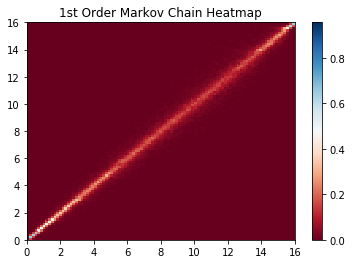

In [30]:
# Heatmap plot

y, x = np.meshgrid(np.linspace(min_wind_power, max_wind_power, n_bins), np.linspace(min_wind_power, max_wind_power, n_bins))

z = np.array(transition_mtx)
#print(z)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = np.abs(z).min(), np.abs(z).max() # Tweak parameter for

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('1st Order Markov Chain Heatmap')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

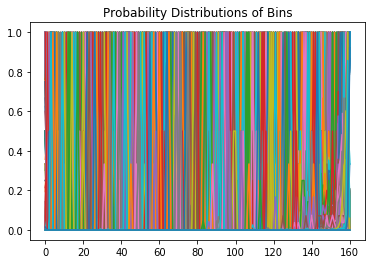

In [12]:
numpy_transition_mtx = np.array(second_order_kernel)

num_plots = 0
for index in range(len(second_order_kernel)):
    plt.plot(numpy_transition_mtx[index,:])
    num_plots += 1
#     if num_plots == 25:
#         break
plt.title("Probability Distributions of Bins")
plt.show()

In [55]:
# Sanity check

for index, row in enumerate(transition_mtx):
    sanity_check = 0
    for idx, col in enumerate(transition_mtx[index]):
        sanity_check += transition_mtx[index][idx]
    print("Row: ", index, " Sum: ", sanity_check)

#print("Sanity Check: ", sanity_check)

('Row: ', 0, ' Sum: ', 1.0000000000000004)
('Row: ', 1, ' Sum: ', 1.0000000000000002)
('Row: ', 2, ' Sum: ', 0.9999999999999999)
('Row: ', 3, ' Sum: ', 1.0000000000000004)
('Row: ', 4, ' Sum: ', 1.0)
('Row: ', 5, ' Sum: ', 0.9999999999999998)
('Row: ', 6, ' Sum: ', 0.9999999999999999)
('Row: ', 7, ' Sum: ', 0.9999999999999998)
('Row: ', 8, ' Sum: ', 1.0000000000000002)
('Row: ', 9, ' Sum: ', 0.9999999999999999)
('Row: ', 10, ' Sum: ', 1.0)
('Row: ', 11, ' Sum: ', 0.9999999999999998)
('Row: ', 12, ' Sum: ', 1.0000000000000002)
('Row: ', 13, ' Sum: ', 1.0)
('Row: ', 14, ' Sum: ', 0.9999999999999998)
('Row: ', 15, ' Sum: ', 0.9999999999999998)
('Row: ', 16, ' Sum: ', 0.9999999999999999)
('Row: ', 17, ' Sum: ', 1.0000000000000002)
('Row: ', 18, ' Sum: ', 0.9999999999999999)
('Row: ', 19, ' Sum: ', 1.0)
('Row: ', 20, ' Sum: ', 0.9999999999999998)
('Row: ', 21, ' Sum: ', 0.9999999999999997)
('Row: ', 22, ' Sum: ', 1.0)
('Row: ', 23, ' Sum: ', 1.0000000000000002)
('Row: ', 24, ' Sum: ', 0.999

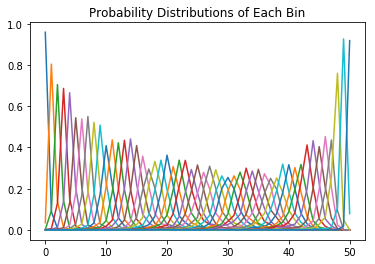

In [54]:
num_plots = 0
for index in range(len(transition_mtx)):
    plt.plot(numpy_transition_mtx[:,index])
    num_plots += 1
#     if num_plots == 25:
#         break
plt.title("Probability Distributions of Each Bin")
plt.show()

In [56]:
for col_idx in range(len(transition_mtx[0])):
    col_sum = 0
    for row_idx, row in enumerate(transition_mtx):
        col_sum += transition_mtx[row_idx][col_idx]
    
    print("Column: ", col_idx, " Sum: ", col_sum)

('Column: ', 0, ' Sum: ', 1.0723892207583376)
('Column: ', 1, ' Sum: ', 0.9999010213125894)
('Column: ', 2, ' Sum: ', 0.9640739706292293)
('Column: ', 3, ' Sum: ', 1.0094299556675328)
('Column: ', 4, ' Sum: ', 1.0679098978192831)
('Column: ', 5, ' Sum: ', 0.9455885144876647)
('Column: ', 6, ' Sum: ', 0.9835930546892393)
('Column: ', 7, ' Sum: ', 0.9985960236373834)
('Column: ', 8, ' Sum: ', 1.0328661650609865)
('Column: ', 9, ' Sum: ', 1.0399622346992377)
('Column: ', 10, ' Sum: ', 0.9506185791973009)
('Column: ', 11, ' Sum: ', 0.9942761086092783)
('Column: ', 12, ' Sum: ', 0.9728947053078884)
('Column: ', 13, ' Sum: ', 1.0007609123170578)
('Column: ', 14, ' Sum: ', 1.0986310469319918)
('Column: ', 15, ' Sum: ', 1.0464956600137147)
('Column: ', 16, ' Sum: ', 0.9622776232512171)
('Column: ', 17, ' Sum: ', 0.9179471019321651)
('Column: ', 18, ' Sum: ', 1.0153762811074474)
('Column: ', 19, ' Sum: ', 0.9921633182381709)
('Column: ', 20, ' Sum: ', 1.0275991666041822)
('Column: ', 21, ' Sum: